# Peaking emissions

* A key step on the way to reducing emissions is for them to peak, at both a national and global level
* This notebook reads in emissions data (either national totals or subsectors) and assesses how many countries have peaked. 
* The criteria for 'peaking' are as follows: 
    * a 'maxima' in emissions was reached 4 or more years before the end of the timeseries
    * over the last 5 years, emissions have decreased
    * [Optional] over the last 5 years, emissions have decreased by a certain amount?
    

In [1]:
# import modules

import sys, os, re

# for analysis
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn

# global stocktake tools
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils


In [2]:
# User specs

data_file_name = 'PRIMAP-hist_v2.0_Energy-CO2.csv'


In [3]:
# Read the data

# read the data from file 
fname_in = os.path.join('proc-data', data_file_name)
data = pd.read_csv(fname_in)

# extract the key information
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]

data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=1, how='any')

#TODO - add some checks / validation

# remove comment below to display the data
#data_years

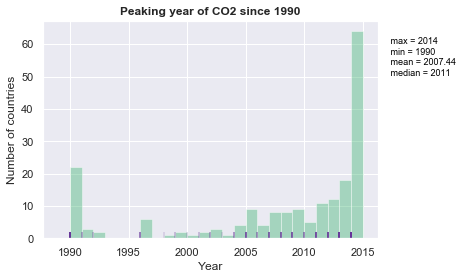

In [5]:
# first idea - year of peaking since 1990

max_emis = data_years.max(axis=1)

year_max = data_years.idxmax(axis=1)
year_max = pd.to_numeric(year_max)
year_max.name = 'peak year'

start_year = min(list(map(int, data_years.columns)))
end_year = max(list(map(int, data_years.columns)))

make_histogram_peaking(year_max, variable, '', start_year, end_year, save_plot=False)
    

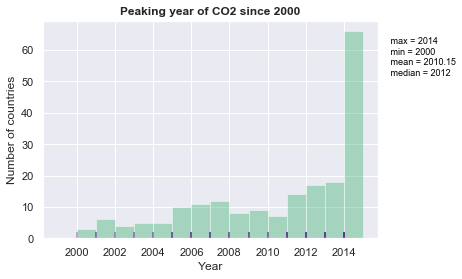

In [6]:
# second idea - year of peaking since 2000

reduced_data = change_first_year(data_years, 2000)

year_max_2000 = reduced_data.idxmax(axis=1)
year_max_2000 = pd.to_numeric(year_max_2000)
year_max_2000.name = 'peak year'

start_year_2000 = min(list(map(int, reduced_data.columns)))
end_year_2000 = max(list(map(int, reduced_data.columns)))

make_histogram_peaking(year_max_2000, variable, '', start_year_2000, end_year_2000, save_plot=False)
    

In [15]:
# part 3 - more nuanced version; what's the current trajectory?
# Fluctuating? Stalled? Or really decreasing? 

peaking_assessment = pd.DataFrame()
peaking_assessment['max year'] = year_max_2000
  
# Both of the options below work! If getting lots of boolean error issues, may just need to restart the kernel...

# Returns true for all countries that have their highest emissions BEFORE the last year of data
peaking_assessment['max_year_reached'] = peaking_assessment['max year'].apply(lambda x : (x < end_year_2000))

peaking_assessment['peak_atleast_5years_ago'] = peaking_assessment['max year'].apply(
                                                                lambda x : (x < (end_year_2000 - 5)))

#peaking_assessment['peaked'] = np.where(peaking_assessment['max year']<=2012, True, False)

peaking_assessment

,max year,max_year_reached,peak_atleast_5years_ago
country,,,
AFG,2011,True,False
AGO,2014,False,False
ALB,2014,False,False
AND,2005,True,True
ARE,2014,False,False
ARG,2014,False,False
ARM,2012,True,False
ATG,2014,False,False
AUS,2009,True,False


In [4]:
def make_histogram_peaking(df, var, unit_, start_year, end_year, save_plot=False):
    
    """
    This is based on the make_simple_histogram function but caters to data that 
    contains both positive and negative values. For the GST, it's important to be 
    able to see whether or not trends etc. are positive or negative and a symmetric
    binning approach is needed. 
    
    To calculate the bin sizes, we use a couple of conditional rules based on the data
    available, including the max and min of the data and the number of data points. 
    For most plots we are expecting around 200 countries, but could also be a few regions. 
    
    TODO - the 'outlier' calculation is helpful to see some data better BUT need to be careful. 
    Proposed solution is to make BOTH plots so that it's clear to the user when data has been
    removed.
    
    TODO - 'df' is actually a series -> better name?
    """
    
    # Check the data - needs to not be, for example, all zeros
    if len(df.unique()) == 1:
        print('---------')
        print('All values in the series are the same! Exiting plotting routine for ' + str(var))
        print('---------')
        return
    
    # set a style
    sns.set(style="darkgrid") 
    
    
    # STATS
    # get some basic info about the data to use for setting styles, calculating bin sizes, and annotating plot
    maximum = int(max(df))
    minimum = int(min(df))
    mean = np.mean(df)
    median = np.median(df)
    npts = len(df) 

    # determine bin edges - annual!
    bin_width = 1 
    bins_calc = range((start_year-1), (end_year + 2), bin_width)                        
        
           
    # --------------        
    # MAKE THE PLOT
    
    # set up the figure
    fig, axs = plt.subplots()

    # make histogram
    sns.distplot(df, kde=False,
                 bins=bins_calc,
                 rug=True, 
                 color='mediumseagreen',
                 rug_kws={"color": "rebeccapurple", "alpha": 0.7, "linewidth": 0.4, "height": 0.03})

    # Dynamically set x axis range to make symmetric abut 0
    if minimum < 0:
        # get and reset xmin or xmax
        xmin, xmax = axs.get_xlim()
        if np.absolute(xmax) > np.absolute(xmin):
            plt.xlim(-xmax, xmax)
        else:
            plt.xlim(xmin, -xmin)
        
        # and add a line at 0
        axs.axvline(linewidth=1, color='k')
           
    # Annotate the plot with stats
    axs.annotate((" max = {:.0f}".format(maximum) + 
                  "\n min = {:.0f}".format(minimum) + 
                  "\n mean = {:.2f}".format(mean) + 
                  "\n median = {:.0f}".format(median)),
                xy=(1.03, 0.75), xycoords=axs.transAxes,
                fontsize=9, color='black', 
                bbox=dict(facecolor='white', alpha=0.75))
    
    # label axes and add title
    axs.set_xlabel('Year')
    axs.set_ylabel('Number of countries')
    axs.set_title(('Peaking year of ' + var + ' since ' + str(start_year)), fontweight='bold')
    
    # show the plot
    plt.show()
    
    # save to file
    if save_plot:
        filepath = os.path.join('output', 'plots')
        fname = ('basic_histogram-' + var + '.pdf')
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        filename = os.path.join(filepath, fname)
        plt.savefig(filename, format='pdf')
        plt.close()

def change_first_year(df, new_start_year):

    # reduce the number of years (keeps things lighter and faster)
    year_cols = [y for y in df[df.columns] if (re.match(r"[0-9]{4,7}$", str(y)) is not None)]
    other_cols = list(set(df.columns) - set(year_cols))

    # set other columns as index
    if other_cols:
        df = df.set_index(other_cols)
    
    # identify which years to keep 
    last_year = max(year_cols)
    years_to_keep = np.arange(new_start_year, (int(last_year)+1), 1)
    years_keep_str = list(map(str, years_to_keep))

    # remove extra years
    df = df.loc[:, years_keep_str]

    # return other columns
    if other_cols:
        df = df.set_index(other_cols)
    # TODO - modify so that the output index is the same as the input!
    
    return df
        

In [86]:
del(peaking_assessment)
peaking_assessment

NameError: name 'peaking_assessment' is not defined